# Ames Housing Prices - Step 2: Data Prep
In this phase, we will build a data prep pipeline to handle outliers and missing data.

In [1]:
# Basic setup
%run ./config.ipynb

Cortex Python SDK v5.5.0


In [2]:
# Connect to Cortex 5
cortex = Cortex.client()

In [3]:
# Retrieve training dataset from Cortex
train_ds = cortex.dataset('kaggle/ames-housing-train')

## Pipelines
Each Cortex 5 Dataset can have multiple named pipelines which are chains of Python functions that transfor the dataset for specific purposes (e.g. data cleaning, feature prep, feature framing, etc.).  We begin here by creating a _clean_ pipeline that will handle remove unwanted columns, handle missing data, remove outliers.

In [4]:
pipeline = train_ds.pipeline('clean')
pipeline.reset()

### Pipeline Steps
Each step in the pipeline is a Python function that accepts and instance of the pipeline object and a Pandas DataFrame for processing.

In [5]:
def drop_unused(pipeline, df):
    df.drop(columns=['Id'], axis=1, inplace=True)

pipeline.add_step(drop_unused)

In [6]:
def drop_outliers(pipeline, df):
    df.drop(df[(df['GrLivArea'].astype(int)>4000) & (df['SalePrice'].astype(int)<300000)].index, inplace=True)
    
pipeline.add_step(drop_outliers)

In [7]:
def fill_zero_cols(pipeline, df):
    fill_zero_cols = ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'GarageCars']
    [df[i].fillna(0, inplace=True) for i in fill_zero_cols]

pipeline.add_step(fill_zero_cols)

### Using the Pipeline Memory
Each pipeline has a memory, called _context_ that is useful for recording state that needs to be used later.  In this case, we are recording the median values of several columns that will be used to fill in missing values for those columns.  We need these median values later when encounter test instances and need to fill in the same missing values.

In [8]:
def fill_median_cols(pipeline, df):
    fill_median_cols = ['GarageArea','TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt']
    [pipeline.set_context('{}_median'.format(j), np.asscalar(df[j].astype(float).median())) for j in fill_median_cols]
    [df[j].fillna(df[j].astype(float).median(), inplace=True) for j in fill_median_cols]
    
pipeline.add_step(fill_median_cols)

In [9]:
def fill_na_none(pipeline, df):
    df.fillna('none', inplace=True)

pipeline.add_step(fill_na_none)

### Running the Pipeline
The pipeline _run_ method will run each of our steps in order and return a transformed DataFrame instance.  We need to save the Dataset at the end to save our

In [10]:
train_df = pipeline.run(train_ds.as_pandas())
train_ds = train_ds.save()

running pipeline [clean]:
> drop_unused 
> drop_outliers 
> fill_zero_cols 
> fill_median_cols 
> fill_na_none 


---
Lets validate that our pipeline solved our missing data and outliers problem.

In [11]:
viz = train_ds.visuals(train_df, figsize=(24, 9))

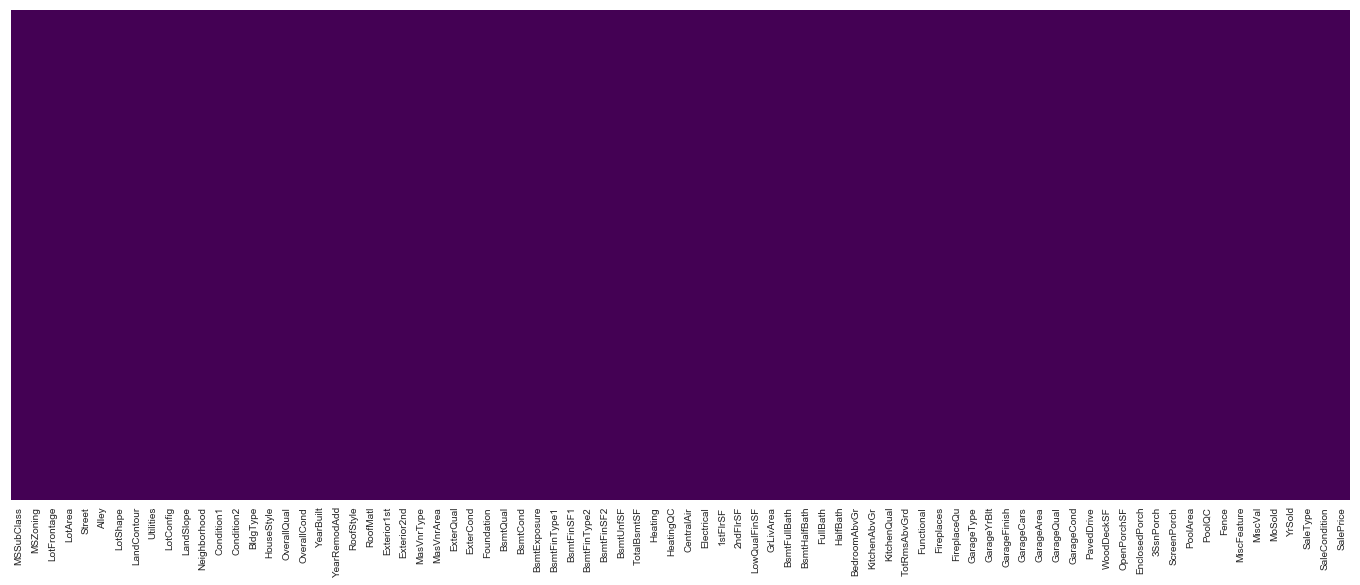

<Figure size 1728x648 with 0 Axes>

In [13]:
viz.show_missing()

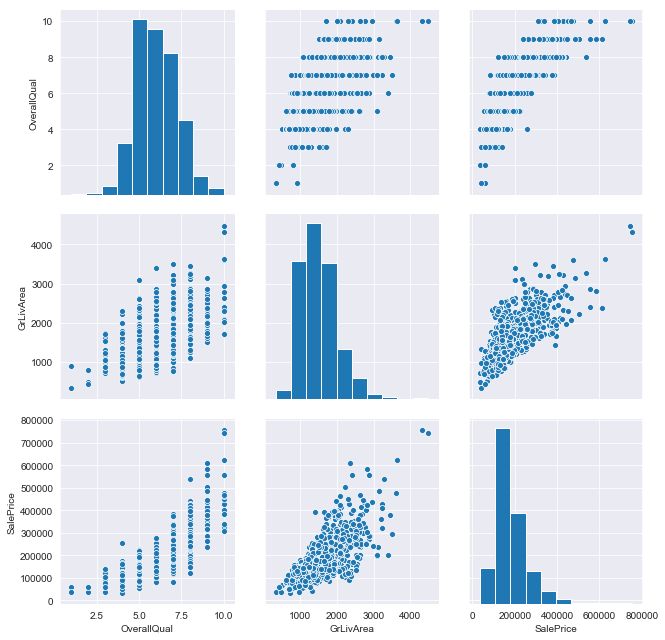

<Figure size 1728x648 with 0 Axes>

In [14]:
viz.show_corr_pairs('SalePrice', threshold=0.7)